In [1]:
!pip install tensorflow-addons
!pip install git+https://www.github.com/keras-team/keras-contrib
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/master thesis/code/xai-tsc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.8 MB/s eta 0:00:00
  Cloning https://www.github.com/keras-team/keras-contrib to /tmp/pip-req-build-y44rqhhi
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib /tmp/pip-req-build-y44rqhhi
  Resolved https://www.github.com/keras-team/keras-contrib to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101058 sha256=0324883bf9fdbf64c592e3a76a62695d3e550c5dc5bdf7680209a781f9433f65
  Stored in directory: /tmp/pip-ephem-wheel-cache-tcevg8_o/wheels/f9/d5/fe/883253892023a0ee62cc0a8d57dc9ae22635258dca2c510ec0
Successfully built keras-contrib
Mounted at /content/drive
/content/drive/My Drive/master thesis/code/xai-tsc


In [2]:
def norm(values):
    if not type(values) == np.ndarray:
        return normalize(values.numpy().reshape(1,-1))[0]
    else:
        return normalize(values.reshape(1,-1))[0]

In [3]:
dataset = 'GunPoint'
model_type = 'resnet'
model = 'resnet'
itr = 0
root_dir =  "/content/drive/My Drive/master thesis/code/xai-tsc"
#'G:/Meine Ablage/master thesis/code/xai-tsc'
archive = 'ucr'
dataset_name = 'GunPoint'
archive_name = 'ucr'
task  = 1
data_source = 'original'


import tensorflow_addons as tfa
from utils.explanations import integrated_gradients
from utils.explanations import calculate_cam_attributions
from keras.utils import CustomObjectScope
import tensorflow.keras as keras
import tensorflow as tf
import os
from utils.explanations import minmax_norm
from utils.explanations import calculate_ig_attributions
#from utils.explanations import calculate_cam_attributions
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils.utils import read_dataset
from sklearn.preprocessing import normalize
import numpy as np
import sklearn


def get_new_training_data(model, itr, dataset_name,  att_method):
    #Hardcoded --> Rework

    archive = 'ucr'
    #Load Dataset
    datasets_dict = read_dataset(root_dir, archive_name, dataset_name, 'original', 1)
    x_train, y_train, x_test, y_test = datasets_dict[dataset_name]

    #calcualte attributions
    if att_method == 'cam':
        attributions = calculate_cam_attributions(root_dir, archive, f"{model}_{itr}", dataset_name, 'original',  experiment=1, scale='normalized')
    elif att_method == 'ig':
        attributions = calculate_ig_attributions(root_dir, archive, f"{model}_{itr}", dataset_name, 'original',  experiment=1, scale='normalized')

    #transform labels
    enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
    enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
    y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
    y_test = enc.transform(y_test.reshape(-1, 1)).toarray()
    #Calculate y values for output 2
    y_train_2 = []
    for e in attributions[0]:
        y_train_2.append(e[2])
    y_train_2 = np.array(y_train_2)
    y_test_2 = []
    for e in attributions[1]:
        y_test_2.append(e[2])
    y_test_2 = np.array(y_test_2)

    return x_train, y_train, y_train_2, x_test, y_test, y_test_2

x_train, y_train, y_train_2, x_test, y_test, y_test_2 = get_new_training_data('resnet', 2, 'GunPoint', 'cam')


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [29]:

from utils.explanations import get_layer_index
from utils.constants import CAM_LAYERS
import pandas as pd

def predict_attributions_head_2(model, dataset_name, att_method):

  ITERATIONS = 3

  results = pd.DataFrame(columns=["linear_output","tanh_output","conv1d_output","build_deep_nn","build_encoder"])

  for itr in range(ITERATIONS):
      print( f'./results/ucr/{dataset_name}/experiment_1/{model}/{model}_{itr}/original/best_model.hdf5')
      model_link  = f'./results/ucr/{dataset_name}/experiment_1/{model}/{model}_{itr}/original/best_model.hdf5'
      loaded_model = keras.models.load_model(model_link ,compile=False)

      x_train, y_train, y_train_2, x_test, y_test, y_test_2 = get_new_training_data(model, itr, dataset_name,  att_method)
      #Sanity Check 1: Check if layers are really freezed by checking prediction
      pred1 = loaded_model.predict(x_train)[0]

      #yvals = 2
      ylen = len(x_train[0])

      # Existing model
      existing_model = loaded_model  # Your existing model

      # Select the index of the layer until which you want to freeze
      freeze_until_layer_index = get_layer_index(loaded_model,CAM_LAYERS[model]["last_conv_layer"])

      # Create a new model with frozen layers
      frozen_model = tf.keras.Model(inputs=existing_model.input, outputs=existing_model.layers[freeze_until_layer_index].output)

      weights_for_output_1 = existing_model.layers[get_layer_index(existing_model,'task_1_output')].get_weights()

      # Freeze the layers of the frozen_model
      for layer in frozen_model.layers:
          layer.trainable = False

      # Create new output functions
      output_function_1 = tf.keras.layers.GlobalAveragePooling1D()(frozen_model.output)

      output_function_1 = tf.keras.layers.Dense(len(y_train[0]), activation='softmax', trainable=False, name='task_1_output')(output_function_1)

      #Flatten Output Intermediate
      flatten = keras.layers.Flatten()(frozen_model.output)
      #Conv1D  Output Intermediate
      conv1d = keras.layers.Conv1DTranspose(filters=1, kernel_size=3,padding='same',activation="linear")(frozen_model.output)
      conv1d_flatten =  keras.layers.Flatten()(conv1d)


      def linear_output():
          output_function_2 = tf.keras.layers.Dense(ylen, activation='linear', name='task_2_output')(flatten)
          return output_function_2

      def tanh_output():
          output_function_2 = tf.keras.layers.Dense(ylen, activation='tanh', name='task_2_output')(flatten)
          return output_function_2

      def conv1d_output():
          output_function_2 =  keras.layers.Conv1DTranspose(filters=1, kernel_size=3,padding='same',activation="linear", name='task_2_output')(frozen_model.output)
          return output_function_2

      #Deep Neural Network
      def build_deep_nn():
          interm_function_1 = tf.keras.layers.Dense(2*ylen, activation='relu')(conv1d_flatten)
          interm_function_2 = tf.keras.layers.Dense(2*ylen, activation='relu')(interm_function_1)
          interm_function_3 = tf.keras.layers.Dense(2*ylen, activation='relu')(interm_function_2)
          output_function_2 = tf.keras.layers.Dense(ylen, activation='linear', name='task_2_output')(interm_function_3)
          return output_function_2


      def build_encoder():
          conv4 = keras.layers.Conv1DTranspose(filters=128, kernel_size=3, padding='same')(frozen_model.output)
          conv4 = keras.layers.Activation('relu')(conv4)
          conv5 = keras.layers.Conv1DTranspose(filters=256, kernel_size=5, padding='same')(conv4)
          conv5 = keras.layers.Activation('relu')(conv5)
          conv6 = keras.layers.Conv1DTranspose(filters=128, kernel_size=8, padding='same')(conv5)
          conv6 = keras.layers.Activation('relu')(conv6)
          output_function_2 = keras.layers.Conv1DTranspose(filters=1, kernel_size=3,padding='same',activation="linear",name='task_2_output')(conv6)
          return output_function_2

      #Loop over task specific heads:
      heads = [linear_output, tanh_output, conv1d_output, build_deep_nn, build_encoder]
      metric_pd = dict()

      for head in heads:

          output_function_2 = head()

          # Create the final model with frozen layers and new output functions
          final_model = tf.keras.Model(inputs=frozen_model.input, outputs=[output_function_1, output_function_2])

          for layer in final_model.layers:
              if 'shared' in layer.name or 'task_1_output' in layer.name:
                  layer.trainable = False

          weights = final_model.get_weights()

          final_model.compile(
          optimizer = keras.optimizers.Adam(),
          loss={'task_1_output': 'categorical_crossentropy','task_2_output': 'mse'},
          loss_weights={'task_1_output': 0, 'task_2_output': 1},
          metrics=['accuracy'])

          final_model.set_weights(weights)
          final_model.layers[get_layer_index(final_model,'task_1_output')].set_weights(weights_for_output_1)

          metric = "loss"
          hist = final_model.fit(
          {'input_1': x_train},
          {'task_1_output': y_train, 'task_2_output': y_train_2},
          batch_size=3,
          epochs= 50,
          verbose=False,
          validation_data=(
              x_test,
              {'task_1_output': y_test, 'task_2_output': y_test_2}))

          pred2 = final_model.predict(x_train)[0][0]
          #Check if Predictions after training remain the same:
          if not (pred1==pred2)[0]: break

          metric_pd[head.__name__] = {
              f"min_mse_{itr}" : np.min(hist.history['val_' + metric]),
              f"min_epo_{itr}" : int(np.argmin(hist.history['val_' + metric]))
          }

      results = results.append(pd.DataFrame(metric_pd))
  results.to_csv(f"./results_csv/Experiment1b/{dataset_name}_{model}_{att_method}_{itr}.csv")
  return results



### GunPoint

In [5]:
dataset_name = 'GunPoint'
fcn_cam_3 = predict_attributions_head_2('fcn', dataset_name,'cam')
resnet_cam_3 = predict_attributions_head_2('resnet', dataset_name,'cam')
fcn_ig_3 = predict_attributions_head_2('fcn', dataset_name,'cam')
resnet_ig_3 = predict_attributions_head_2('resnet', dataset_name,'ig')

2/2 [==============================] - 0s 15ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 29ms/step


<ipython-input-4-0468c216372c>:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


2/2 [==============================] - 0s 5ms/step


<ipython-input-4-0468c216372c>:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


2/2 [==============================] - 0s 5ms/step


<ipython-input-4-0468c216372c>:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


2/2 [==============================] - 0s 8ms/step


<ipython-input-4-0468c216372c>:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


2/2 [==============================] - 0s 7ms/step


<ipython-input-4-0468c216372c>:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


2/2 [==============================] - 1s 7ms/step


<ipython-input-4-0468c216372c>:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


2/2 [==============================] - 0s 6ms/step


<ipython-input-4-0468c216372c>:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


2/2 [==============================] - 0s 6ms/step


<ipython-input-4-0468c216372c>:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


2/2 [==============================] - 0s 7ms/step


<ipython-input-4-0468c216372c>:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


/content/drive/My Drive/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_1/resnet/resnet_0/original/last_model.hdf5
2/2 [==============================] - 0s 7ms/step


<ipython-input-4-0468c216372c>:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


/content/drive/My Drive/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_1/resnet/resnet_1/original/last_model.hdf5
2/2 [==============================] - 0s 7ms/step


<ipython-input-4-0468c216372c>:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


/content/drive/My Drive/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_1/resnet/resnet_2/original/last_model.hdf5
2/2 [==============================] - 0s 7ms/step


<ipython-input-4-0468c216372c>:125: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


In [16]:
print("fcn cam")
display(fcn_cam_3)
print("resnet cam")
display(resnet_cam_3)
print("fcn ig")
display(fcn_ig_3)
print("resnet ig")
display(resnet_ig_3)

fcn cam


,linear_output,tanh_output,conv1d_output,build_deep_nn,build_encoder
min_mse,1.198114,0.991611,0.007464,0.002467,0.002101
min_epo,48.000000,0.000000,48.000000,45.000000,47.000000
min_mse,0.928932,0.995163,0.007729,0.003022,0.002146
min_epo,47.000000,0.000000,46.000000,49.000000,41.000000
min_mse,2.416440,0.983862,0.007987,0.002126,0.002693
min_epo,27.000000,0.000000,44.000000,48.000000,43.000000


resnet cam


,linear_output,tanh_output,conv1d_output,build_deep_nn,build_encoder
min_mse,9.581282,0.983709,0.017880,0.002893,0.000914
min_epo,28.000000,2.000000,49.000000,48.000000,47.000000
min_mse,4.500206,0.982662,0.015491,0.002010,0.001793
min_epo,42.000000,0.000000,49.000000,49.000000,49.000000
min_mse,3.339709,0.987519,0.024111,0.002898,0.000739
min_epo,49.000000,0.000000,47.000000,45.000000,47.000000


fcn ig


,linear_output,tanh_output,conv1d_output,build_deep_nn,build_encoder
min_mse,2.094132,0.983816,0.008756,0.001967,0.002331
min_epo,34.000000,0.000000,46.000000,42.000000,45.000000
min_mse,1.896063,0.986077,0.007625,0.002872,0.002217
min_epo,9.000000,0.000000,41.000000,45.000000,48.000000
min_mse,3.097453,0.987887,0.007595,0.002224,0.002772
min_epo,33.000000,1.000000,47.000000,41.000000,47.000000


resnet ig


,linear_output,tanh_output,conv1d_output,build_deep_nn,build_encoder
min_mse,7.038853,0.997559,0.019373,0.003657,0.002764
min_epo,43.000000,0.000000,47.000000,44.000000,49.000000
min_mse,6.098522,0.989577,0.017222,0.004453,0.001475
min_epo,41.000000,0.000000,49.000000,49.000000,36.000000
min_mse,5.122548,1.000361,0.025400,0.003773,0.001569
min_epo,20.000000,1.000000,49.000000,42.000000,49.000000


### Beef


In [30]:
dataset_name = 'Beef'
fcn_cam_3 = predict_attributions_head_2('fcn', dataset_name,'cam')
resnet_cam_3 = predict_attributions_head_2('resnet', dataset_name,'cam')
fcn_ig_3 = predict_attributions_head_2('fcn', dataset_name,'cam')
resnet_ig_3 = predict_attributions_head_2('resnet', dataset_name,'ig')

./results/ucr/Beef/experiment_1/fcn/fcn_0/original/best_model.hdf5
1/1 [==============================] - 0s 291ms/step
./results/ucr/Beef/experiment_1/fcn/fcn_1/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


1/1 [==============================] - 0s 247ms/step
./results/ucr/Beef/experiment_1/fcn/fcn_2/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


1/1 [==============================] - 0s 263ms/step
./results/ucr/Beef/experiment_1/resnet/resnet_0/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


1/1 [==============================] - 0s 489ms/step
./results/ucr/Beef/experiment_1/resnet/resnet_1/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


1/1 [==============================] - 0s 494ms/step
./results/ucr/Beef/experiment_1/resnet/resnet_2/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


1/1 [==============================] - 1s 512ms/step
./results/ucr/Beef/experiment_1/fcn/fcn_0/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


1/1 [==============================] - 0s 294ms/step
./results/ucr/Beef/experiment_1/fcn/fcn_1/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


1/1 [==============================] - 0s 256ms/step
./results/ucr/Beef/experiment_1/fcn/fcn_2/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


1/1 [==============================] - 0s 281ms/step
./results/ucr/Beef/experiment_1/resnet/resnet_0/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


/content/drive/My Drive/master thesis/code/xai-tsc/results/ucr/Beef//experiment_1/resnet/resnet_0/original/last_model.hdf5
1/1 [==============================] - 0s 497ms/step
./results/ucr/Beef/experiment_1/resnet/resnet_1/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


/content/drive/My Drive/master thesis/code/xai-tsc/results/ucr/Beef//experiment_1/resnet/resnet_1/original/last_model.hdf5
1/1 [==============================] - 0s 481ms/step
./results/ucr/Beef/experiment_1/resnet/resnet_2/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


/content/drive/My Drive/master thesis/code/xai-tsc/results/ucr/Beef//experiment_1/resnet/resnet_2/original/last_model.hdf5
1/1 [==============================] - 0s 496ms/step


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


In [31]:
print("fcn cam")
display(fcn_cam_3)
print("resnet cam")
display(resnet_cam_3)
print("fcn ig")
display(fcn_ig_3)
print("resnet ig")
display(resnet_ig_3)

fcn cam


,linear_output,tanh_output,conv1d_output,build_deep_nn,build_encoder
min_mse_0,9.294813,0.996098,0.014700,0.000706,0.001439
min_epo_0,16.000000,4.000000,49.000000,42.000000,48.000000
min_mse_1,7.712457,1.000117,0.013481,0.000764,0.001948
min_epo_1,34.000000,0.000000,49.000000,48.000000,41.000000
min_mse_2,6.517764,1.000893,0.008856,0.000435,0.001477
min_epo_2,49.000000,0.000000,49.000000,43.000000,49.000000


resnet cam


,linear_output,tanh_output,conv1d_output,build_deep_nn,build_encoder
min_mse_0,20.717794,0.999612,0.089335,0.001371,0.001503
min_epo_0,9.000000,0.000000,49.000000,21.000000,48.000000
min_mse_1,42.646885,0.996795,0.046156,0.001467,0.001569
min_epo_1,7.000000,0.000000,49.000000,47.000000,37.000000
min_mse_2,62.895996,0.999017,0.064170,0.002075,0.002052
min_epo_2,15.000000,0.000000,49.000000,13.000000,49.000000


fcn ig


,linear_output,tanh_output,conv1d_output,build_deep_nn,build_encoder
min_mse_0,8.048748,1.001417,0.010844,0.000884,0.001533
min_epo_0,13.000000,4.000000,47.000000,47.000000,48.000000
min_mse_1,3.256719,0.999039,0.010361,0.000631,0.001912
min_epo_1,10.000000,0.000000,49.000000,41.000000,49.000000
min_mse_2,10.947296,1.000542,0.011795,0.000453,0.001635
min_epo_2,17.000000,0.000000,49.000000,44.000000,47.000000


resnet ig


,linear_output,tanh_output,conv1d_output,build_deep_nn,build_encoder
min_mse_0,45.629990,0.997089,0.043333,0.002130,0.002030
min_epo_0,5.000000,0.000000,49.000000,6.000000,48.000000
min_mse_1,67.476288,0.999775,0.049653,0.002140,0.001872
min_epo_1,21.000000,0.000000,49.000000,5.000000,42.000000
min_mse_2,46.689590,1.000318,0.032242,0.001881,0.002007
min_epo_2,29.000000,0.000000,49.000000,33.000000,48.000000


### ECG200

In [32]:
dataset_name = 'ECG200'
fcn_cam_3 = predict_attributions_head_2('fcn', dataset_name,'cam')
resnet_cam_3 = predict_attributions_head_2('resnet', dataset_name,'cam')
fcn_ig_3 = predict_attributions_head_2('fcn', dataset_name,'cam')
resnet_ig_3 = predict_attributions_head_2('resnet', dataset_name,'ig')

./results/ucr/ECG200/experiment_1/fcn/fcn_0/original/best_model.hdf5
4/4 [==============================] - 0s 34ms/step
./results/ucr/ECG200/experiment_1/fcn/fcn_1/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


4/4 [==============================] - 0s 4ms/step
./results/ucr/ECG200/experiment_1/fcn/fcn_2/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


4/4 [==============================] - 0s 4ms/step
./results/ucr/ECG200/experiment_1/resnet/resnet_0/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


4/4 [==============================] - 1s 6ms/step
./results/ucr/ECG200/experiment_1/resnet/resnet_1/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


4/4 [==============================] - 1s 5ms/step
./results/ucr/ECG200/experiment_1/resnet/resnet_2/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


4/4 [==============================] - 0s 4ms/step
./results/ucr/ECG200/experiment_1/fcn/fcn_0/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


4/4 [==============================] - 0s 4ms/step
./results/ucr/ECG200/experiment_1/fcn/fcn_1/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


4/4 [==============================] - 0s 4ms/step
./results/ucr/ECG200/experiment_1/fcn/fcn_2/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


4/4 [==============================] - 0s 4ms/step
./results/ucr/ECG200/experiment_1/resnet/resnet_0/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


/content/drive/My Drive/master thesis/code/xai-tsc/results/ucr/ECG200//experiment_1/resnet/resnet_0/original/last_model.hdf5
4/4 [==============================] - 1s 5ms/step
./results/ucr/ECG200/experiment_1/resnet/resnet_1/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


/content/drive/My Drive/master thesis/code/xai-tsc/results/ucr/ECG200//experiment_1/resnet/resnet_1/original/last_model.hdf5
4/4 [==============================] - 0s 4ms/step
./results/ucr/ECG200/experiment_1/resnet/resnet_2/original/best_model.hdf5


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


/content/drive/My Drive/master thesis/code/xai-tsc/results/ucr/ECG200//experiment_1/resnet/resnet_2/original/last_model.hdf5
4/4 [==============================] - 1s 5ms/step


<ipython-input-29-106ee5e65ab6>:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd))


In [33]:
print("fcn cam")
display(fcn_cam_3)
print("resnet cam")
display(resnet_cam_3)
print("fcn ig")
display(fcn_ig_3)
print("resnet ig")
display(resnet_ig_3)

fcn cam


,linear_output,tanh_output,conv1d_output,build_deep_nn,build_encoder
min_mse_0,0.847154,0.966242,0.016829,0.004533,0.005629
min_epo_0,27.000000,0.000000,46.000000,34.000000,34.000000
min_mse_1,0.483531,0.966737,0.016102,0.005486,0.005523
min_epo_1,21.000000,0.000000,45.000000,49.000000,20.000000
min_mse_2,0.950559,0.975403,0.011702,0.005093,0.004594
min_epo_2,25.000000,13.000000,49.000000,41.000000,46.000000


resnet cam


,linear_output,tanh_output,conv1d_output,build_deep_nn,build_encoder
min_mse_0,1.538883,0.976960,0.024601,0.003630,0.001927
min_epo_0,41.000000,3.000000,49.000000,40.000000,40.000000
min_mse_1,2.435415,0.993744,0.038263,0.007181,0.003649
min_epo_1,25.000000,1.000000,49.000000,48.000000,48.000000
min_mse_2,3.807330,0.980013,0.020968,0.004361,0.003407
min_epo_2,49.000000,0.000000,49.000000,44.000000,39.000000


fcn ig


,linear_output,tanh_output,conv1d_output,build_deep_nn,build_encoder
min_mse_0,1.116315,0.951226,0.016097,0.004647,0.005501
min_epo_0,42.000000,0.000000,48.000000,48.000000,48.000000
min_mse_1,1.036883,0.971716,0.015234,0.005638,0.005354
min_epo_1,43.000000,0.000000,45.000000,46.000000,31.000000
min_mse_2,1.357149,0.968936,0.017932,0.005197,0.004647
min_epo_2,9.000000,1.000000,47.000000,48.000000,31.000000


resnet ig


,linear_output,tanh_output,conv1d_output,build_deep_nn,build_encoder
min_mse_0,1.955459,0.990917,0.032552,0.007715,0.004862
min_epo_0,45.000000,3.000000,46.000000,43.000000,43.000000
min_mse_1,3.997161,0.984181,0.051841,0.007547,0.004788
min_epo_1,41.000000,0.000000,49.000000,34.000000,49.000000
min_mse_2,2.801550,0.996870,0.022143,0.008460,0.006344
min_epo_2,46.000000,0.000000,49.000000,48.000000,40.000000


### Visualization



1/1 [==============================] - 0s 402ms/step


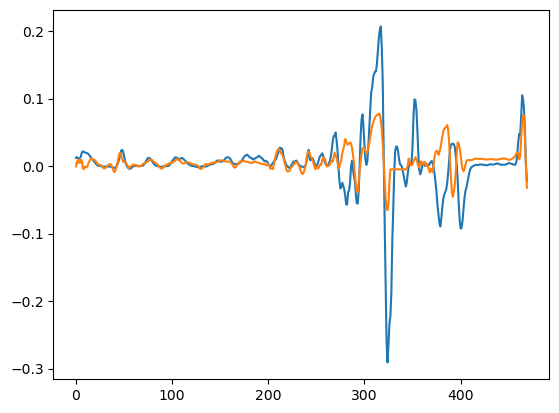

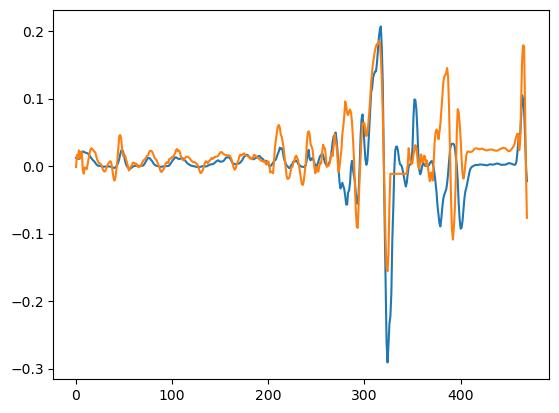

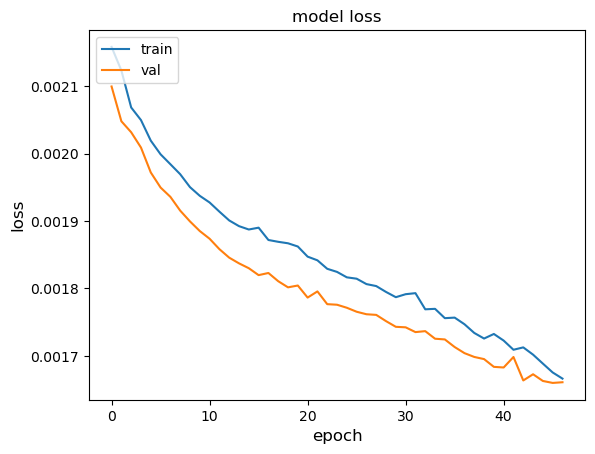

In [ ]:
%matplotlib inline
ts = 25

plt.plot(y_val_2[ts])
pr = final_model.predict(x_test)
#print(pr[1][ts])
plt.plot(pr[1][ts])
plt.show()


plt.plot(norm(y_val_2[ts]))
plt.plot(norm(pr[1][ts]))
skip_first_epochs = 3

metric = "loss"
plt.figure()
plt.plot(hist.history[metric][skip_first_epochs:])
plt.plot(hist.history['val_' + metric][skip_first_epochs:])
plt.title('model ' + metric)
plt.ylabel(metric, fontsize='large')
plt.xlabel('epoch', fontsize='large')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
ig_link  = f'./results/ucr/{dataset}/experiment_1/{model_type}/{model}_{itr}/{model_type}_ig_raw/last_model.hdf5'
ig_model = keras.models.load_model(ig_link ,compile=False)


# Existing model
existing_model = ig_model.layers[:9]

existing_model